<h1><center> OCT PROJET 


<h2> Imports

In [27]:
import os
from PIL import Image, ImageTk
from random import randint

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt, savgol_filter
import tkinter as tk
from tkinter import filedialog, messagebox


<h2> Normalisation des images

In [28]:
# recopie de la configuration des répertoires pour les outputs
BASE_DATA_PATH = "./"
IMAGE_DIR = os.path.join(BASE_DATA_PATH, "IMAGES/IMAGES/")
ALL_IMAGES_DIR = [os.path.join(IMAGE_DIR, x) for x in os.listdir(IMAGE_DIR)]
OUTPUT_DIR = os.path.join(BASE_DATA_PATH, "OUTPUT_CROPPED")
ALL_OUTPUT_DIR = [os.path.join(OUTPUT_DIR, x+"_cropped") for x in os.listdir(IMAGE_DIR)]

[os.makedirs(x, exist_ok=True) for x in ALL_OUTPUT_DIR]
os.makedirs(OUTPUT_DIR, exist_ok=True)

CROP_X_START = 520
CROP_Y_START = 20   
# CROP_X_END = 2000 est codé dynamiquement en fonction de l'image
CROP_Y_END = 450   

In [29]:

# --- Fonctions ---
def load_image(image_path):
    img = cv2.imread(image_path) # Charger en couleur au cas où pour l'affichage
    if img is None:
        print(f"Erreur : Impossible de charger l'image à {image_path}")
    return img

def crop_image(image, x_start, y_start, x_end, y_end):
    if image is None:
        return None
    # S'assurer que les coordonnées sont valides
    h, w = image.shape[:2]
    x_s = max(0, x_start)
    y_s = max(0, y_start)
    x_e = min(w, x_end)
    y_e = min(h, y_end)

    if x_s >= x_e or y_s >= y_e:
        print(f"Erreur de recadrage: coordonnées invalides ({x_s},{y_s}) à ({x_e},{y_e}) pour une image de taille {w}x{h}")
        return image # ou None
    
    cropped = image[y_s:y_e, x_s:x_e]
    return cropped

def display_comparison(original_img, cropped_img, title_original="Originale", title_cropped="Recadrée"):
    if original_img is None or cropped_img is None:
        print("Une des images est None, impossible d'afficher.")
        return
        
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(title_original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title(title_cropped)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def display_image(image):
    
    plt.imshow(image, cmap='gray')
    plt.show()


def get_image_tif_files(DIR):
    
    return glob.glob(os.path.join(DIR, "*.tif"))
    
def get_image_png_files(DIR):
    
    return glob.glob(os.path.join(DIR, "*.png"))

In [30]:
def crop_bscan(all_input_directory : list ,all_output_directory:list, debug = False , type="png"):
    ''' 
    Recadre les B-scans d'une série d'images en fonction des coordonnées définies    
    Arguments:
        - all_input_directory (list) :  répertoires contenant les images à réduire
        - debug (bool): si true, active les prints
        - type (str): type de fichier à traiter, ici png
        - all_output_directory (list): répertoires de sortie pour les images recadrées
    '''

    for indice,image_dir in enumerate(all_input_directory):
        image_files = glob.glob(os.path.join(image_dir, f"*.{type}")) # Ou .png, .jpg
        if not image_files:
            print(f"Aucun fichier .tif trouvé dans {image_dir}. Vérifiez le chemin et l'extension.")
            exit()

        for img_path in image_files:

            if debug:
                print(f"Traitement de : {img_path}")

            current_full_image = load_image(img_path)
            largeur = current_full_image.shape[1] - 10
            if current_full_image is not None:
                current_cropped_bscan = crop_image(current_full_image, CROP_X_START, CROP_Y_START, largeur, CROP_Y_END)
                if current_cropped_bscan is not None and current_cropped_bscan.size > 0:
                    output_filename = os.path.join(all_output_directory[indice], "cropped_" + os.path.basename(img_path))
                    cv2.imwrite(output_filename, current_cropped_bscan)

                    if debug:
                        print(f"  -> Sauvegardée : {output_filename}")
                else:
                    if debug:
                        print(f"  -> Échec du recadrage pour {img_path}")

<h3> Crop de toutes les images

In [ ]:
# crop_bscan(ALL_IMAGES_DIR,ALL_OUTPUT_DIR)
# si on ne veux que traiter un seul repertoire il faut en faire une liste de 1 répertoire

<h1> Segmentation de la rétine

<h2> Décomposition en 3 méthodes différentes


Méthode n°1 : 
<br>-Prétraitement (par B-scan recadré) : Améliorer la qualité de l'image pour faciliter la segmentation.
<br>-Segmentation de l'ILM (Internal Limiting Membrane) : C'est la première interface hyper-réflective (brillante) en partant du vitré (la zone sombre en haut).
<br>-Segmentation de la Limite Externe du HRC (Hyper-Reflective Complex) : C'est une autre couche brillante, plus profonde que l'ILM. Sa position est souvent relative à l'ILM.
<br>-Post-traitement : Lisser les courbes segmentées, combler les petits trous.

In [32]:
def pre_filtrage(cropped_bscan):

    gray_bscan = cv2.cvtColor(cropped_bscan, cv2.COLOR_BGR2GRAY)

    # Filtre Gaussien
    blurred = cv2.GaussianBlur(gray_bscan, (5, 5), 0) # Ajustez la taille du noyau

    # Ou Filtre Médian (bon pour le bruit poivre et sel)
    blurred = cv2.medianBlur(gray_bscan, 5)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced = clahe.apply(blurred)
    image_to_process = contrast_enhanced
    # Ou utiliser 'blurred' directement si le contraste est déjà bon
    return blurred

In [33]:
def segment_ilm_gradient_based(image_processed):
    ilm_line = np.zeros(image_processed.shape[1], dtype=int)
    # Réduire la zone de recherche pour l'ILM (par exemple, le tiers supérieur de l'image)
    search_roi_y_end = image_processed.shape[0] 

    for x in range(image_processed.shape[1]):
        column = image_processed[:search_roi_y_end, x]
        
        # Calculer le gradient vertical (différence simple ou Sobel)
        # grad_y = np.diff(column.astype(float)) # Simple diff, longueur N-1
        # Ou utiliser Sobel pour un gradient plus robuste
        sobel_y = cv2.Sobel(column, cv2.CV_64F, 0, 1, ksize=3) # Gradient en Y

        # Trouver le premier pic positif important
        # On cherche une transition sombre -> clair, donc un gradient positif important
        # (ou un pic négatif si on utilise diff et qu'on regarde la valeur d'avant)
        
        # Simplification: trouver le premier pixel au-dessus d'un seuil après lissage
        # Cette partie est très similaire à la méthode simple mais sur une image mieux préparée
        # et avec un ROI. Une vraie détection de pic de gradient serait mieux.
        
        # Pour une approche "premier pixel au-dessus d'un seuil dans ROI" (plus simple à coder ici)
        threshold_val = np.mean(column) + np.std(column) # Seuil adaptatif simple
        potential_points = np.where(column > threshold_val)[0]

        if len(potential_points) > 0:
            ilm_line[x] = potential_points[0]
        else:
            # Gérer le cas où rien n'est trouvé (ex: prendre la moyenne des voisins)
            if x > 0:
                ilm_line[x] = ilm_line[x-1] 
            else:
                ilm_line[x] = search_roi_y_end // 2 # Estimation grossière
    return ilm_line

def segment_hrc_relative_to_ilm(image_processed, ilm_line, search_offset=30, search_height=100):
    hrc_line = np.zeros(image_processed.shape[1], dtype=int)
    
    for x in range(image_processed.shape[1]):
        start_y_hrc = ilm_line[x] + search_offset
        end_y_hrc = min(image_processed.shape[0], start_y_hrc + search_height)
        
        if start_y_hrc >= end_y_hrc: # Si l'ILM est trop basse ou la bande trop petite
             if x > 0: hrc_line[x] = hrc_line[x-1]
             else: hrc_line[x] = ilm_line[x] + search_offset + search_height//2
             continue

        column_roi = image_processed[start_y_hrc:end_y_hrc, x]
        
        if column_roi.size == 0:
            if x > 0: hrc_line[x] = hrc_line[x-1]
            else: hrc_line[x] = ilm_line[x] + search_offset + search_height//2
            continue

        # Trouver le pixel le plus brillant dans ce ROI
        # Ceci est une simplification. Une détection de gradient ou de pic serait mieux.
        max_intensity_idx_in_roi = np.argmax(column_roi)
        hrc_line[x] = start_y_hrc + max_intensity_idx_in_roi
        
    return hrc_line

In [34]:
def segment_hrc_band(image_processed, ilm_line,
                     offset_to_hrc_top_search_start=25, # Augmenté par défaut
                     hrc_complex_search_height=100,
                     hrc_band_expected_min_thickness=10,
                     hrc_band_expected_max_thickness=50,
                     hrc_top_brightness_factor_vs_ilm=1.15, # HRC_top doit être X% plus brillant que l'ILM
                     hrc_top_brightness_factor_vs_roi_mean=1.0 # HRC_top doit être X * std_dev au-dessus de la moyenne ROI HRC
                    ):
    hrc_top_line = np.zeros(image_processed.shape[1], dtype=float)
    hrc_bottom_line = np.zeros(image_processed.shape[1], dtype=float)
    img_height, img_width = image_processed.shape

    for x in range(img_width):
        # Définir la ROI verticale globale pour chercher le complexe HRC
        # S'assurer que ilm_line[x] est un index valide
        current_ilm_y = int(ilm_line[x])
        if not (0 <= current_ilm_y < img_height): # Si ILM est hors limites, fallback
            current_ilm_y = img_height // 3 # Estimation grossière

        search_roi_start_y = current_ilm_y + offset_to_hrc_top_search_start
        search_roi_end_y = min(img_height, search_roi_start_y + hrc_complex_search_height)

        # S'assurer que la ROI est valide et a une taille minimale
        if search_roi_start_y >= img_height or search_roi_start_y >= search_roi_end_y or (search_roi_end_y - search_roi_start_y) < 5 :
            hrc_top_line[x] = hrc_top_line[x-1] if x > 0 else current_ilm_y + offset_to_hrc_top_search_start + 5
            hrc_bottom_line[x] = hrc_bottom_line[x-1] if x > 0 else hrc_top_line[x] + hrc_band_expected_min_thickness + 5
            hrc_top_line[x] = min(max(0, hrc_top_line[x]), img_height -1) # Clamp
            hrc_bottom_line[x] = min(max(0, hrc_bottom_line[x]), img_height -1) # Clamp
            continue

        column_hrc_roi = image_processed[int(search_roi_start_y):int(search_roi_end_y), x]

        if column_hrc_roi.size == 0: # Devrait être couvert par la vérification précédente, mais par sécurité
            hrc_top_line[x] = hrc_top_line[x-1] if x > 0 else current_ilm_y + offset_to_hrc_top_search_start + 5
            hrc_bottom_line[x] = hrc_bottom_line[x-1] if x > 0 else hrc_top_line[x] + hrc_band_expected_min_thickness + 5
            hrc_top_line[x] = min(max(0, hrc_top_line[x]), img_height -1)
            hrc_bottom_line[x] = min(max(0, hrc_bottom_line[x]), img_height -1)
            continue

        # --- Trouver HRC_top ---
        current_hrc_top_local_idx = -1

        # Définir un seuil d'intensité exigeant pour HRC_top
        intensity_at_ilm = image_processed[current_ilm_y, x]
        
        # Seuil 1: basé sur la brillance relative à l'ILM
        threshold_vs_ilm = intensity_at_ilm * hrc_top_brightness_factor_vs_ilm
        
        # Seuil 2: basé sur la distribution de la ROI HRC
        mean_roi = np.mean(column_hrc_roi)
        std_roi = np.std(column_hrc_roi)
        threshold_vs_roi_stat = mean_roi + hrc_top_brightness_factor_vs_roi_mean * std_roi
        
        # Le seuil final est le plus strict des deux (ou d'autres combinaisons)
        # Ici, on prend le max, ce qui signifie que le pixel doit satisfaire les deux conditions si elles sont pertinentes
        # Ou une condition OU l'autre, selon la logique (ici, on prend le max pour être plus strict)
        final_threshold_top = max(threshold_vs_ilm, threshold_vs_roi_stat, mean_roi + 5) # Ajout d'un seuil minimal au-dessus de la moyenne

        # Chercher le premier pixel dans column_hrc_roi qui dépasse ce seuil strict
        # On limite la recherche à la première partie de la ROI pour éviter confusion avec HRC_bottom
        search_limit_hrc_top_local = len(column_hrc_roi) * 2 // 3 # ex: chercher dans les 2/3 supérieurs de la ROI HRC
        
        potential_top_indices = np.where(column_hrc_roi[:search_limit_hrc_top_local] > final_threshold_top)[0]
        
        if len(potential_top_indices) > 0:
            current_hrc_top_local_idx = potential_top_indices[0]
        else:
            # Fallback si le seuil strict ne trouve rien:
            # Chercher le pixel le plus brillant dans la première moitié de la ROI HRC.
            # Cela peut arriver si l'HRC n'est pas aussi brillant que prévu par les facteurs.
            first_half_roi = column_hrc_roi[:len(column_hrc_roi)//2]
            if first_half_roi.size > 0:
                current_hrc_top_local_idx = np.argmax(first_half_roi)
            else: # Si même la première moitié est vide (ROI très petite)
                current_hrc_top_local_idx = 0 # Prendre le début de la ROI

        # Si current_hrc_top_local_idx est toujours -1 (ce qui ne devrait pas arriver avec le fallback argmax),
        # ou s'il est trop bas dans la ROI (ce qui contredit l'idée de "top")
        # Ce fallback est moins probable maintenant.
        if current_hrc_top_local_idx == -1 : # Ne devrait plus arriver
             max_intensity_idx_in_overall_roi = np.argmax(column_hrc_roi)
             current_hrc_top_local_idx = max(0, max_intensity_idx_in_overall_roi - hrc_band_expected_min_thickness//2) # Estimation

        hrc_top_line[x] = search_roi_start_y + current_hrc_top_local_idx


        # --- Trouver HRC_bottom ---
        # (La logique pour HRC_bottom reste globalement la même que votre version précédente,
        # mais elle commence sa recherche à partir du HRC_top trouvé)

        # Assurer que HRC_top n'est pas trop bas pour laisser de la place à HRC_bottom
        # Et que start_search_bottom_local_idx est valide
        # On veut que HRC_bottom soit au moins quelques pixels après HRC_top
        min_dist_top_to_start_bottom = max(1, hrc_band_expected_min_thickness // 3) # Ex: au moins 1/3 de l'épaisseur min
        start_search_bottom_local_idx = int(current_hrc_top_local_idx + min_dist_top_to_start_bottom)
        
        # S'assurer que start_search_bottom_local_idx ne dépasse pas la fin de column_hrc_roi
        if start_search_bottom_local_idx >= len(column_hrc_roi):
            # Si HRC_top est trop proche de la fin de la ROI, HRC_bottom est juste un peu après
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_min_thickness
            hrc_bottom_line[x] = min(hrc_bottom_line[x], search_roi_end_y -1) # borner
            # Il faut s'assurer que top et bottom sont cohérents dans le script principal après lissage
            continue # Passer à la colonne suivante

        sub_roi_for_bottom = column_hrc_roi[start_search_bottom_local_idx:]
        current_hrc_bottom_local_idx = -1

        if sub_roi_for_bottom.size > 0:
            max_intensity_idx_in_sub_roi = np.argmax(sub_roi_for_bottom)
            intensity_at_max_in_sub_roi = sub_roi_for_bottom[max_intensity_idx_in_sub_roi]
            
            # Seuil pour HRC_bottom: un certain pourcentage de l'intensité max trouvée dans la sous-ROI
            # Ou un peu plus bas que HRC_top si HRC_top est le plus brillant de toute la bande
            threshold_bottom = intensity_at_max_in_sub_roi * 0.85 # Doit être encore assez brillant (ajustable)
            # S'assurer que threshold_bottom n'est pas trop bas si toute la bande est peu contrastée
            threshold_bottom = max(threshold_bottom, mean_roi * 0.9) # Au moins 90% de la moyenne de la ROI HRC

            last_bright_pixel_idx_in_sub_roi = max_intensity_idx_in_sub_roi # Initialiser
            for i in range(max_intensity_idx_in_sub_roi, len(sub_roi_for_bottom)):
                if sub_roi_for_bottom[i] >= threshold_bottom:
                    last_bright_pixel_idx_in_sub_roi = i
                else:
                    # On peut ajouter une condition pour ne pas s'arrêter trop tôt si c'est juste un petit creux
                    # Si les N prochains pixels sont aussi sous le seuil, alors on s'arrête.
                    # Pour l'instant, on s'arrête au premier passage sous le seuil.
                    break
            current_hrc_bottom_local_idx = start_search_bottom_local_idx + last_bright_pixel_idx_in_sub_roi
        
        if current_hrc_bottom_local_idx == -1: # Fallback si sub_roi_for_bottom était vide ou autre souci
            max_intensity_idx_in_overall_roi = np.argmax(column_hrc_roi) # Reprendre la ROI HRC complète
            # Placer HRC_bottom un peu après le HRC_top trouvé ou le max global
            offset_from_top = max(hrc_band_expected_min_thickness, (max_intensity_idx_in_overall_roi - current_hrc_top_local_idx) if max_intensity_idx_in_overall_roi > current_hrc_top_local_idx else hrc_band_expected_min_thickness)
            current_hrc_bottom_local_idx = min(len(column_hrc_roi)-1, current_hrc_top_local_idx + offset_from_top)

        hrc_bottom_line[x] = search_roi_start_y + current_hrc_bottom_local_idx

        # --- Vérifications finales pour la colonne x ---
        # S'assurer que HRC_bottom est après HRC_top
        if hrc_bottom_line[x] <= hrc_top_line[x]:
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_min_thickness

        # S'assurer que l'épaisseur est dans les limites attendues (si possible)
        current_thickness = hrc_bottom_line[x] - hrc_top_line[x]
        if current_thickness < hrc_band_expected_min_thickness:
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_min_thickness
        elif current_thickness > hrc_band_expected_max_thickness:
            # Si trop épais, on peut soit remonter HRC_bottom soit descendre HRC_top.
            # Remonter HRC_bottom est souvent plus sûr si HRC_top est bien placé.
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_max_thickness
        
        # Clamper les valeurs pour qu'elles restent dans les limites de l'image
        hrc_top_line[x] = min(max(0, hrc_top_line[x]), img_height - 1)
        hrc_bottom_line[x] = min(max(0, hrc_bottom_line[x]), img_height - 1)
        
        # S'assurer que bottom est toujours après top après clamping et ajustements d'épaisseur
        if hrc_bottom_line[x] < hrc_top_line[x]:
            hrc_bottom_line[x] = hrc_top_line[x] # Au pire, épaisseur nulle, à gérer après lissage

    return hrc_top_line.astype(int), hrc_bottom_line.astype(int)

<h3> Post Filtrage

In [35]:
def post_filtrage(ilm_line, hrc_lines):
    """ il faut appliquer un gros filtre pour enlever les taches noires ! """
    # Appliquer un filtre médian
    ilm_line_smooth = medfilt(ilm_line, kernel_size=15).astype(int) # Ajustez kernel_size
    hrc_line_top_smooth = medfilt(hrc_lines[0], kernel_size=35).astype(int)
    hrc_line_bot_smooth = medfilt(hrc_lines[1], kernel_size=35).astype(int)

    return ilm_line_smooth, hrc_line_top_smooth,hrc_line_bot_smooth    

<h3>Découpage des zones en masques

In [ ]:
def create_and_save_retinal_layer_masks(
    ilm_line,
    hrc_top_line,
    hrc_bottom_line,
    image_shape,
    output_directory="mask_result",
    base_filename="mask",
    debug = False
):
    """
    Crée et sauvegarde les masques binaires pour deux couches rétiniennes :
    1. La couche entre l'ILM (ligne supérieure) et le HRC_top (couche "supra-HRC").
    2. La bande HRC (entre HRC_top et HRC_bottom).

    Les masques sont sauvegardés en format PNG avec des valeurs de 0 (noir) et 255 (blanc).

    Args:
        ilm_line (np.array): Array 1D des positions Y de la ligne ILM.
        hrc_top_line (np.array): Array 1D des positions Y de la bordure supérieure du HRC.
        hrc_bottom_line (np.array): Array 1D des positions Y de la bordure inférieure du HRC.
        image_shape (tuple): Forme (hauteur, largeur) de l'image de référence.
        output_directory (str): Dossier où sauvegarder les masques.
        base_filename (str): Nom de base pour les fichiers de masques sauvegardés.
        visualize (bool): Si True, affiche les masques générés.
    """
    img_height, img_width = image_shape

    # Vérification de la cohérence des longueurs des lignes
    if not (len(ilm_line) == img_width and \
            len(hrc_top_line) == img_width and \
            len(hrc_bottom_line) == img_width):
        raise ValueError("La longueur des lignes (ILM, HRC_top, HRC_bottom) "
                         "doit correspondre à la largeur de l'image.")

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(output_directory, exist_ok=True)

    # --- Masque 1: Couche "Supra-HRC" (entre ILM et HRC_top) ---
    mask_supra_hrc = np.zeros(image_shape, dtype=np.uint8)
    for x in range(img_width):
        y_start_supra = int(ilm_line[x])
        y_end_supra = int(hrc_top_line[x]) # HRC_top est la limite *exclusive* de cette couche

        # S'assurer que les coordonnées sont valides et que y_end est après y_start
        if 0 <= y_start_supra < img_height and \
           0 <= y_end_supra < img_height and \
           y_start_supra < y_end_supra: # Strictement inférieur car HRC_top est le début de la couche suivante
            mask_supra_hrc[y_start_supra:y_end_supra, x] = 1
            # Si ilm_line est la PREMIERE ligne de la couche et hrc_top_line est la PREMIERE ligne
            # de la couche HRC, alors la couche supra-HRC va de ilm_line[x] inclus à hrc_top_line[x] exclus.
            # Le slicing [start:end] fait exactement cela.

    # --- Masque 2: Bande HRC (entre HRC_top et HRC_bottom) ---
    mask_hrc_band = np.zeros(image_shape, dtype=np.uint8)
    for x in range(img_width):
        y_start_hrc = int(hrc_top_line[x])
        # hrc_bottom_line est considérée comme la DERNIÈRE ligne incluse dans la bande HRC
        y_end_hrc_inclusive = int(hrc_bottom_line[x])

        # S'assurer que les coordonnées sont valides et que y_end est après ou égale à y_start
        if 0 <= y_start_hrc < img_height and \
           0 <= y_end_hrc_inclusive < img_height and \
           y_start_hrc <= y_end_hrc_inclusive:
            mask_hrc_band[y_start_hrc : min(img_height, y_end_hrc_inclusive + 1), x] = 1

    # Sauvegarde des masques (en multipliant par 255 pour la visibilité)
    supra_hrc_mask_filename = os.path.join(output_directory, f"{base_filename}_mask_supra_HRC.png")
    hrc_band_mask_filename = os.path.join(output_directory, f"{base_filename}_mask_HRC_band.png")

    try:
        cv2.imwrite(supra_hrc_mask_filename, mask_supra_hrc * 255)
        if debug:
            print(f"Masque Supra-HRC sauvegardé : {supra_hrc_mask_filename}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de {supra_hrc_mask_filename}: {e}")

    try:
        cv2.imwrite(hrc_band_mask_filename, mask_hrc_band * 255)
        if debug:
            print(f"Masque Bande HRC sauvegardé : {hrc_band_mask_filename}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de {hrc_band_mask_filename}: {e}")

    return mask_supra_hrc, mask_hrc_band 

In [ ]:

def main_1(all_input_directory:list,visualisation=False):

    i=-1
    for image_directory in all_input_directory:
        image_files = get_image_tif_files(image_directory)
        image_files = get_image_png_files(image_directory)
        
        for image_path in image_files:
            file_name = os.path.splitext(os.path.basename(image_path))[0]
            image = load_image(image_path)
            i+=1
            
            pre_filtre = pre_filtrage(image)
            ilm = segment_ilm_gradient_based(pre_filtre)
            hrc = segment_hrc_band(pre_filtre, ilm)
            ilm_smooth, hrc_top_smooth,hrc_bot_smooth = post_filtrage(ilm, hrc)
            masks = create_and_save_retinal_layer_masks(ilm_smooth,hrc_top_smooth,\
                     hrc_bot_smooth,image.shape[0:2],base_filename=file_name)

            if (i+randint(0,10))%100==0 and visualisation:
                print('\n\nimage originale')
                display_image(image)
                print('image pré-filtrée')
                display_image(pre_filtre)
                print('ILM détectée')
                plt.plot(ilm, label='ILM')
                plt.plot(hrc[0], label='HRC_top')
                plt.plot(hrc[1], label='HRC_bot')
                print('image_pré-filtrée avec ILM et HRC')
                display_image(pre_filtre)
                plt.plot(ilm_smooth, label='ILM')
                plt.plot(hrc_top_smooth, label='HRC_top')
                plt.plot(hrc_bot_smooth, label='HRC_bot')
                print('image_pré-filtrée avec ILM et HRC lissées')
                display_image(pre_filtre)
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(masks[0], cmap='gray')
                plt.title("Masque Couche Supra-HRC")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(masks[1], cmap='gray')
                plt.title("Masque Bande HRC")
                plt.axis('off')
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()
                


Partie d'execution

195 ./OUTPUT_CROPPED\05_MIG_OD_cropped\cropped_MIG_OD003.png


image originale


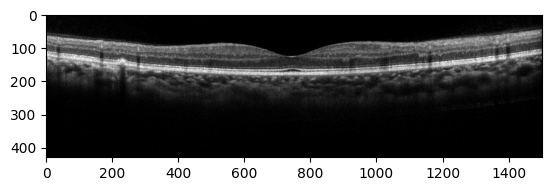

image pré-filtrée


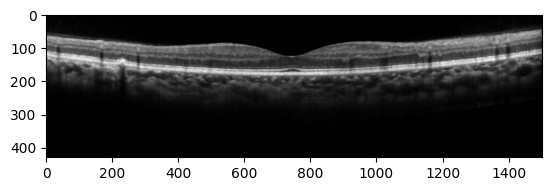

ILM détectée
image_pré-filtrée avec ILM et HRC


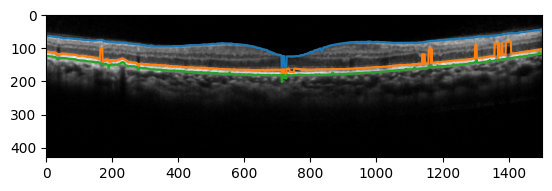

image_pré-filtrée avec ILM et HRC lissées


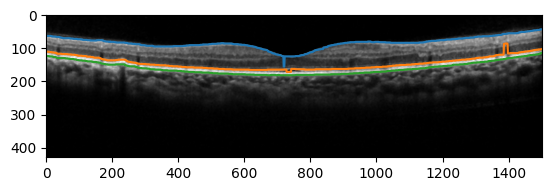

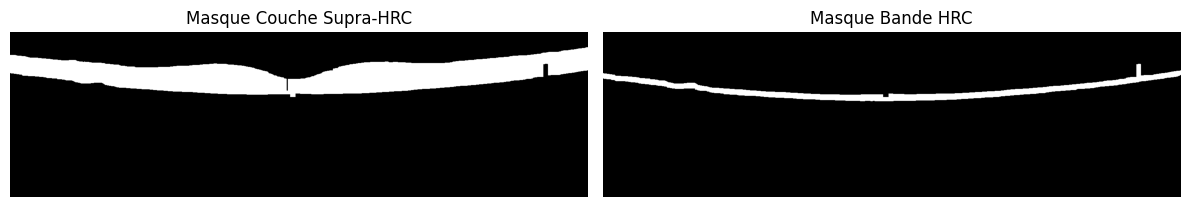

297 ./OUTPUT_CROPPED\08_TRK_OD_cropped\cropped_TRK_OD009.png


image originale


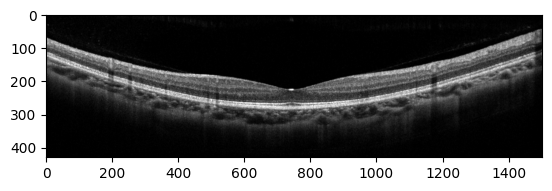

image pré-filtrée


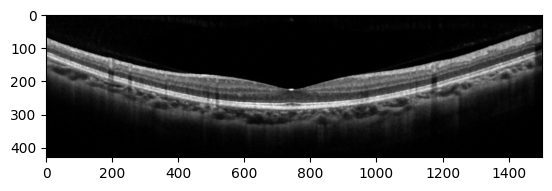

ILM détectée
image_pré-filtrée avec ILM et HRC


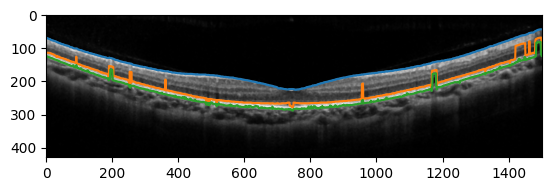

image_pré-filtrée avec ILM et HRC lissées


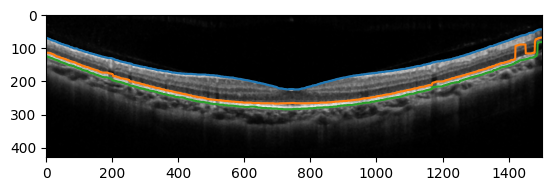

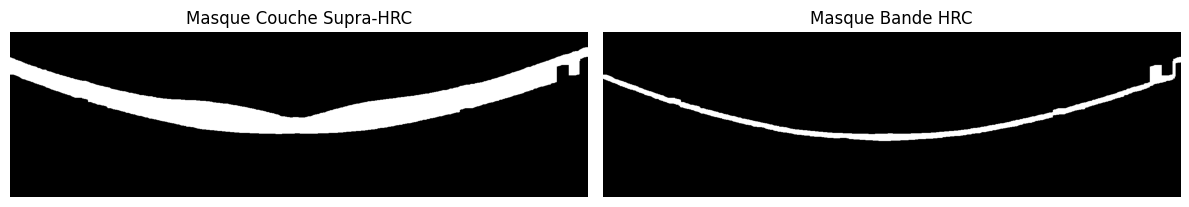

In [41]:
main_1(ALL_OUTPUT_DIR,True)

# si on ne veux que traiter un seul repertoire il faut en faire une liste de 1 répertoire

<h2> Méthode n°3 Deep learning ave U-net

Voir TD9 de VPO

<h1> outil de navigation de données


In [39]:
class DualImageNavigatorVerticalStrict: 
    def __init__(self, root):
        self.root = root
        self.root.title("Comparateur d'Images (Superposé Strict)")
        self.root.geometry("800x800")

        # --- Cadre principal ---
        main_frame = tk.Frame(root)
        main_frame.pack(expand=True, fill="both")

        main_frame.grid_rowconfigure(0, weight=1) 
        main_frame.grid_rowconfigure(1, weight=1)
     
        main_frame.grid_columnconfigure(0, weight=1)

        # --- Données pour le panneau HAUT ---
        self.image_list_top = []
        self.current_index_top = -1
        self.image_tk_top = None

        # --- Données pour le panneau BAS ---
        self.image_list_bottom = []
        self.current_index_bottom = -1
        self.image_tk_bottom = None

        self.panel_top = self.create_image_panel(main_frame, "top")
        self.panel_top.grid(row=0, column=0, sticky="nsew", padx=5, pady=5) 

   
        self.panel_bottom = self.create_image_panel(main_frame, "bottom")
        self.panel_bottom.grid(row=1, column=0, sticky="nsew", padx=5, pady=5)

        self.root.bind('<a>', lambda event: self.prev_image('top'))
        self.root.bind('<d>', lambda event: self.next_image('top'))
        self.root.bind('<Left>', lambda event: self.prev_image('bottom'))
        self.root.bind('<Right>', lambda event: self.next_image('bottom'))

    def create_image_panel(self, parent_frame, panel_id):
        panel_frame = tk.LabelFrame(parent_frame, text=f"Panneau {panel_id.capitalize()}", padx=10, pady=10)
    
        controls_frame = tk.Frame(panel_frame)
        controls_frame.pack(pady=5, fill="x")

        btn_choose_folder = tk.Button(controls_frame, text="Choisir Dossier",
                                      command=lambda p_id=panel_id: self.load_folder(p_id))
        btn_choose_folder.pack(side=tk.LEFT, padx=2)

        btn_prev = tk.Button(controls_frame, text="<<",
                             command=lambda p_id=panel_id: self.prev_image(p_id), state=tk.DISABLED)
        btn_prev.pack(side=tk.LEFT, padx=2)
        setattr(self, f"btn_prev_{panel_id}", btn_prev)

        btn_next = tk.Button(controls_frame, text=">>",
                             command=lambda p_id=panel_id: self.next_image(p_id), state=tk.DISABLED)
        btn_next.pack(side=tk.LEFT, padx=2)
        setattr(self, f"btn_next_{panel_id}", btn_next)

        lbl_info = tk.Label(controls_frame, text="Aucune image")
        lbl_info.pack(side=tk.LEFT, padx=5, expand=True, fill="x")
        setattr(self, f"lbl_info_{panel_id}", lbl_info)

        image_display_frame = tk.Frame(panel_frame, relief="sunken", borderwidth=1)
        image_display_frame.pack(expand=True, fill="both")
        image_display_frame.pack_propagate(False) 
        setattr(self, f"image_display_frame_{panel_id}", image_display_frame)

        lbl_image = tk.Label(image_display_frame)
        lbl_image.pack(expand=True, fill="both")
        setattr(self, f"lbl_image_{panel_id}", lbl_image)

        return panel_frame

    def load_folder(self, panel_id):
        folder_path = filedialog.askdirectory()
        if not folder_path: return

        image_list = []
        valid_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.tif', '.webp')
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(valid_extensions):
                image_list.append(os.path.join(folder_path, filename))

        if not image_list:
            messagebox.showinfo("Info", f"Aucune image trouvée pour le panneau {panel_id}.")
            current_index = -1
            getattr(self, f"lbl_image_{panel_id}").config(image='')
            setattr(self, f"image_tk_{panel_id}", None)
        else:
            image_list.sort()
            current_index = 0

        setattr(self, f"image_list_{panel_id}", image_list)
        setattr(self, f"current_index_{panel_id}", current_index)

        if image_list:
            self.root.update_idletasks()
            self.display_image(panel_id)

        self.update_button_states(panel_id)
        self.update_image_info(panel_id)

    def display_image(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        lbl_image_widget = getattr(self, f"lbl_image_{panel_id}")
        image_display_frame = getattr(self, f"image_display_frame_{panel_id}")

        if not image_list or current_index < 0:
            lbl_image_widget.config(image='')
            setattr(self, f"image_tk_{panel_id}", None)
            return

        image_path = image_list[current_index]
        try:
            img_pil = Image.open(image_path)
            image_display_frame.update_idletasks()
            frame_width = image_display_frame.winfo_width()
            frame_height = image_display_frame.winfo_height()

            if frame_width <= 1 or frame_height <= 1:
                self.root.update_idletasks() 
                parent_panel_frame = image_display_frame.master 
                parent_panel_frame.update_idletasks()

                frame_width = parent_panel_frame.winfo_width() - 20
                frame_height = parent_panel_frame.winfo_height() - (getattr(self, f"controls_frame_{panel_id}", controls_frame).winfo_height() + 20) # -hauteur controles et padding

                if frame_width <=1 : frame_width = 300
                if frame_height <=1 : frame_height = 200


            img_width, img_height = img_pil.size
            if img_width == 0 or img_height == 0:
                raise ValueError("Image dimensions are zero.")
            
            ratio = min(frame_width / img_width, frame_height / img_height)

            new_width = max(1, int(img_width * ratio))
            new_height = max(1, int(img_height * ratio))
            img_resized = img_pil.resize((new_width, new_height), Image.Resampling.LANCZOS)

            image_tk = ImageTk.PhotoImage(img_resized)
            lbl_image_widget.config(image=image_tk)
            setattr(self, f"image_tk_{panel_id}", image_tk) 

        except Exception as e:
            messagebox.showerror("Erreur", f"Panneau {panel_id}: Impossible de charger {image_path}\n{e}")
            if image_list: 
                image_list.pop(current_index)
                if current_index >= len(image_list) and image_list:
                    current_index = len(image_list) -1
                elif not image_list:
                    current_index = -1
                setattr(self, f"current_index_{panel_id}", current_index)
                if current_index != -1: self.display_image(panel_id)
                else:
                    lbl_image_widget.config(image='')
                    setattr(self, f"image_tk_{panel_id}", None)
            self.update_button_states(panel_id)
            self.update_image_info(panel_id)

    def next_image(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        if image_list and current_index < len(image_list) - 1:
            current_index += 1
            setattr(self, f"current_index_{panel_id}", current_index)
            self.display_image(panel_id)
        self.update_button_states(panel_id)
        self.update_image_info(panel_id)

    def prev_image(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        if image_list and current_index > 0:
            current_index -= 1
            setattr(self, f"current_index_{panel_id}", current_index)
            self.display_image(panel_id)
        self.update_button_states(panel_id)
        self.update_image_info(panel_id)

    def update_button_states(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        btn_prev = getattr(self, f"btn_prev_{panel_id}")
        btn_next = getattr(self, f"btn_next_{panel_id}")

        if not image_list or current_index == -1:
            btn_prev.config(state=tk.DISABLED)
            btn_next.config(state=tk.DISABLED)
        else:
            btn_prev.config(state=tk.NORMAL if current_index > 0 else tk.DISABLED)
            btn_next.config(state=tk.NORMAL if current_index < len(image_list) - 1 else tk.DISABLED)

    def update_image_info(self, panel_id):
        image_list = getattr(self, f"image_list_{panel_id}")
        current_index = getattr(self, f"current_index_{panel_id}")
        lbl_info = getattr(self, f"lbl_info_{panel_id}")

        if image_list and current_index != -1:
            filename = os.path.basename(image_list[current_index])
            lbl_info.config(text=f"{current_index + 1}/{len(image_list)}: {filename[:30]}")
        else:
            lbl_info.config(text="Aucune image")

    def create_image_panel(self, parent_frame, panel_id):
        panel_frame = tk.LabelFrame(parent_frame, text=f"Panneau {panel_id.capitalize()}", padx=10, pady=10)

        controls_frame = tk.Frame(panel_frame)
        controls_frame.pack(pady=5, fill="x")
        setattr(self, f"controls_frame_{panel_id}", controls_frame)

        btn_choose_folder = tk.Button(controls_frame, text="Choisir Dossier",
                                      command=lambda p_id=panel_id: self.load_folder(p_id))
        btn_choose_folder.pack(side=tk.LEFT, padx=2)

        btn_prev = tk.Button(controls_frame, text="<<",
                             command=lambda p_id=panel_id: self.prev_image(p_id), state=tk.DISABLED)
        btn_prev.pack(side=tk.LEFT, padx=2)
        setattr(self, f"btn_prev_{panel_id}", btn_prev)

        btn_next = tk.Button(controls_frame, text=">>",
                             command=lambda p_id=panel_id: self.next_image(p_id), state=tk.DISABLED)
        btn_next.pack(side=tk.LEFT, padx=2)
        setattr(self, f"btn_next_{panel_id}", btn_next)

        lbl_info = tk.Label(controls_frame, text="Aucune image")
        lbl_info.pack(side=tk.LEFT, padx=5, expand=True, fill="x")
        setattr(self, f"lbl_info_{panel_id}", lbl_info)

        image_display_frame = tk.Frame(panel_frame, relief="sunken", borderwidth=1)
        image_display_frame.pack(expand=True, fill="both")
        image_display_frame.pack_propagate(False)
        setattr(self, f"image_display_frame_{panel_id}", image_display_frame)

        lbl_image = tk.Label(image_display_frame)
        lbl_image.pack(expand=True, fill="both")
        setattr(self, f"lbl_image_{panel_id}", lbl_image)

        return panel_frame

<h2> Execution du navigateur de données

In [40]:
# root = tk.Tk()
# app = DualImageNavigatorVerticalStrict(root)
# root.mainloop()